# Log of changes from original calculation

* Urban/rural split is now based on MSASIZE instead of URBRUR variable from NHTS. Now "rural" is outside of any MSA, instead of just not in an urbanized region.
* Added an option to include demand from transit trips in addition to private vehicles and taxis.
* Now breaking down into three different times of week: Sa/Su, M/F, and Tu/W/Th.

# Important things to note:
* This provides the *trip* demand, where a trip is point-to-point travel for one or more members of the same household. So if a family of six all takes the bus, that's *one* trip. This has implications for our assumptions about the sharing factor.
* Trips >=300 mi. are thrown out
* This produces *annual* trip demand values. So for the TU/WE/TH midweek time period, this is all trips on all Tuesdays, Wednesdays, and Thursdays for the whole year. Need to multiply by 7/3./365. to get a daily value.

# To do
* Seasonal variation

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
%matplotlib notebook

## Set up

In [72]:
#Point to a directory containing the NHTS trippub.csv dataset
data_dir = 'C:\\Users\\bgerke.DOMINO0\\Desktop\\NHTS\\'

#Should we include demand from trips on mass transit (public transit, school buses, private shuttles, etc.)?
include_transit = False



In [73]:
#Read in main dataset
trippub_all = pd.read_csv(data_dir+'trippub.csv')
trippub_all.head()
#Trips

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,HTRESDN,SMPLSRCE,R_AGE,EDUC,R_SEX,PRMACT,PROXY,WORKER,DRIVER,WTTRDFIN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
2,30000007,2,1,700,900,120,84.004,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
4,30000007,3,1,845,900,15,2.250,3,0,0,...,750,2,28,2,2,5,2,2,1,80122.686739


In [74]:
trippub_all.columns.values

array(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME',
       'TRVLCMIN', 'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       'VEHID', 'TRWAITTM', 'NUMTRANS', 'TRACCTM', 'DROP_PRK', 'TREGRTM',
       'WHODROVE', 'WHYFROM', 'LOOP_TRIP', 'TRPHHVEH', 'HHMEMDRV',
       'HH_ONTD', 'NONHHCNT', 'NUMONTRP', 'PSGR_FLG', 'PUBTRANS',
       'TRIPPURP', 'DWELTIME', 'TDWKND', 'VMT_MILE', 'DRVR_FLG',
       'WHYTRP1S', 'WHYTRP90', 'ONTD_P1', 'ONTD_P2', 'ONTD_P3', 'ONTD_P4',
       'ONTD_P5', 'ONTD_P6', 'ONTD_P7', 'ONTD_P8', 'ONTD_P9', 'ONTD_P10',
       'ONTD_P11', 'ONTD_P12', 'ONTD_P13', 'TDCASEID', 'TRACC_WLK',
       'TRACC_POV', 'TRACC_BUS', 'TRACC_CRL', 'TRACC_SUB', 'TRACC_OTH',
       'TREGR_WLK', 'TREGR_POV', 'TREGR_BUS', 'TREGR_CRL', 'TREGR_SUB',
       'TREGR_OTH', 'WHYTO', 'TRAVDAY', 'HOMEOWN', 'HHSIZE', 'HHVEHCNT',
       'HHFAMINC', 'DRVRCNT', 'HHSTATE', 'HHSTFIPS', 'NUMADLT',
       'WRKCOUNT', 'TDAYDATE', 'HHRESP', 'LIF_CYC', 'MSACAT', 'MSASIZE',
       'RAIL', 'URBAN', '

In [75]:
#Personal motor vehicle codes from code book
#This is car, suv, van, pickup truck,  motorcycle, RV, rental car
#LEAVES OUT 17-taxis/TNCs, because (I believe) we cannot weight these correctly since must weight by driver. 

pmvcodes = [3,4,5,6,8,9,18]
selection = (trippub_all['TRPTRANS'].isin(pmvcodes)) & (trippub_all['DRVR_FLG']==1)


    
trippub = trippub_all.loc[selection]
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())


611342
220429661377.4252


In [76]:
taxitrips = trippub_all.loc[trippub_all['TRPTRANS']==17].groupby(
    ['HOUSEID','TDAYDATE','STRTTIME'], as_index=False).first()
#The above cuts out duplicate trips, where two people in the same household reported the same taxi trip. Serves
#a similar purpose to restricting by driver flag
trippub = trippub.append(taxitrips)
trippub.reset_index(drop=True, inplace=True)
print(taxitrips['TRPTRANS'].count())
print(taxitrips['WTTRDFIN'].sum())
#Surprisingly few taxi trips...

2394
1615969202.3435988


In [77]:
if include_transit:
    print('Including transit trips in total.')
    #Transit vehicle codes from code book are 10-16 
    trnstcodes = list(range(10,17))
    trnsttrips = trippub_all.loc[trippub_all['TRPTRANS'].isin(trnstcodes)].groupby(
        ['HOUSEID','TDAYDATE','STRTTIME'], as_index=False).first()
    trippub = trippub.append(trnsttrips)
    trippub.reset_index(drop=True, inplace=True)
    print(trnsttrips['TRPTRANS'].count())
    print(trnsttrips['WTTRDFIN'].sum())
else:
    print('Excluding transit trips from total')

Excluding transit trips from total


In [78]:
#Total raw and weighted trip numbers
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())

613736
222045630579.7688


In [79]:
#Print avg mileages by trip type
print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())
print(taxitrips['TRPMILES'].mul(taxitrips['WTTRDFIN']).sum()/taxitrips['WTTRDFIN'].sum())
if include_transit: 
    print(trnsttrips['TRPMILES'].mul(trnsttrips['WTTRDFIN']).sum()/trnsttrips['WTTRDFIN'].sum())

9.543193941031108
8.222858752112181


In [80]:
trippub.tail()

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DROP_PRK,DRVRCNT,DRVR_FLG,DWELTIME,EDUC,ENDTIME,...,VEHID,VMT_MILE,WHODROVE,WHYFROM,WHYTO,WHYTRP1S,WHYTRP90,WORKER,WRKCOUNT,WTTRDFIN
613731,91,9,4,1,-1,2,-1,108,4,932,...,-1,-1.0,-1,1,3,10,1,1,2,344957.415508
613732,91,9,4,1,-1,2,-1,65,4,1135,...,-1,-1.0,-1,3,1,1,1,1,2,344957.415508
613733,91,9,4,1,-1,2,-1,-9,4,2025,...,-1,-1.0,-1,7,1,1,10,1,2,408975.662752
613734,91,9,4,1,-1,2,-1,40,4,1200,...,-1,-1.0,-1,2,1,1,11,1,2,422950.854805
613735,91,9,4,1,-1,2,-1,-9,4,1300,...,-1,-1.0,-1,1,2,1,11,1,2,422950.854805


In [81]:
#Trim out long road trips
trippub = trippub.loc[trippub['TRPMILES'] < 300]
print(len(trippub))
print(trippub['WTTRDFIN'].sum())

print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())

613205
221835869978.23254
8.90120102812671


In [82]:
#Create Census Division/ Large State category with urban/rural split.
#Also Census region urban/rural split
cdiv = {1:'NENG', 2:'MAT', 3:'ENC', 4:'WNC', 5:'SAT', 6:'ESC', 7:'WSC', 8:'MTN', 9:'PAC'}
creg = {1:'NEAST', 2:'MIDW', 3:'SOUTH', 4:'WEST'}

for k in cdiv.keys():
    trippub.loc[trippub['CENSUS_D']==k, 'CDIVLS'] = cdiv[k]
for k in creg.keys():
    trippub.loc[trippub['CENSUS_R']==k, 'REGION'] = creg[k]

lgst = ['CA', 'NY','FL','TX']

for s in lgst:
    div = cdiv[trippub.loc[trippub['HHSTATE']==s, 'CENSUS_D'].unique()[0]]
    #print reg
    trippub.loc[(trippub['HHSTATE']==s), 'CDIVLS'] = div+'-'+s
    trippub.loc[(trippub['CDIVLS']==div) & (trippub['HHSTATE']!=s), 'CDIVLS'] = div+'-NL' 
    

#Turn urban/rural codes into strings    
trippub['URBRURS'] = 'RUR'
#trippub.loc[trippub['URBRUR'] == 1, 'URBRURS'] = 'URB'
#Instead of the above, divide urban vs rural according to metropolitan statistical area size: all MSAs are urban
trippub.loc[trippub['MSASIZE']<6,'URBRURS'] = 'URB'


print trippub['CDIVLS'].unique()
print trippub['REGION'].unique()
print trippub['URBRURS'].unique()

['SAT-NL' 'ENC' 'MAT-NY' 'MAT-NL' 'PAC-CA' 'WSC-TX' 'PAC-NL' 'ESC' 'MTN'
 'WNC' 'NENG' 'SAT-FL' 'WSC-NL']
['SOUTH' 'MIDW' 'NEAST' 'WEST']
['URB' 'RUR']


In [83]:
#Code different times of week.
wktime = {'SA/SU':[1,7], 'MO/FR':[2,6], 'TU/WE/TH': [3,4,5]}
trippub['WKTIME'] = ''
for k in wktime.keys():
    trippub.loc[trippub['TRAVDAY'].isin(wktime[k]), 'WKTIME'] = k
print trippub['WKTIME'].unique()

['MO/FR' 'TU/WE/TH' 'SA/SU']


In [84]:
#Set mileage bin edges
mibins=[0,2,5,10,20,30,50,100,300]
mibin_labels=pd.Series(mibins[:-1]).astype(str).str.cat(pd.Series(mibins[1:]).astype(str), sep='-')

In [85]:
#Categorize trips by mileage

trippub['MILEBIN'] = pd.cut(trippub['TRPMILES'], mibins, labels=mibin_labels)


In [86]:
#Compute distance histograms (and average distances) by CDLS

dist_hists = trippub.groupby(['CDIVLS', 'URBRURS',
                              'WKTIME','MILEBIN']).agg({'WTTRDFIN':[len, np.sum], 
                                                               'TRPMILES':np.mean,
                                                               'REGION':'first'}
                                                       ).rename(columns=
                                                                {'mean':'AVGDIST',
                                                                 'first':'REGION', 
                                                                 'len':'COUNTSRAW',
                                                                 'sum':'COUNTSWTD'}, level=1)

dist_hists.columns = dist_hists.columns.droplevel(0)
dist_hists

#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

AVGDIST REGION  COUNTSRAW     COUNTSWTD
CDIVLS URBRURS WKTIME   MILEBIN                                            
ENC    RUR     MO/FR    0-2        0.974638   MIDW     2015.0  7.172323e+08
                        2-5        3.229061   MIDW     1272.0  3.689536e+08
                        5-10       7.307186   MIDW      962.0  2.574709e+08
                        10-20     14.369085   MIDW      872.0  2.688098e+08
                        20-30     24.308613   MIDW      367.0  1.130752e+08
                        30-50     38.296500   MIDW      294.0  7.924429e+07
                        50-100    65.738626   MIDW      147.0  3.291124e+07
                        100-300  164.462368   MIDW       68.0  1.262960e+07
               SA/SU    0-2        0.990884   MIDW      900.0  5.904250e+08
                        2-5        3.263062   MIDW      516.0  3.306223e+08
                        5-10       7.174956   MIDW      363.0  2.181214e+08
                        10-20     13.890219   MIDW      374.0  2.274015e+08
                        20-30     24.590622   MIDW      135.0  9.867586e+07
                        30-50     39.594713   MIDW      108.0  7.227111e+07
                        50-100    65.750533   MIDW       92.0  3.914405e+07
                        100-300  157.425613   MIDW       31.0  1.656451e+07
               TU/WE/TH 0-2        0.968638   MIDW     2966.0  8.372957e+08
                        2-5        3.265039   MIDW     1835.0  5.502475e+08
                        5-10       7.273006   MIDW     1437.0  4.489847e+08
                        10-20     14.320166   MIDW     1346.0  5.147868e+08
                        20-30     24.388382   MIDW      558.0  1.765248e+08
                        30-50     38.339401   MIDW      459.0  1.483422e+08
                        50-100    67.393056   MIDW      177.0  4.410430e+07
                        100-300  156.786339   MIDW       59.0  1.006733e+07
       URB     MO/FR    0-2        1.085843   MIDW     5294.0  2.227462e+09
                        2-5        3.300086   MIDW     5525.0  2.255926e+09
                        5-10       7.133211   MIDW     3646.0  1.564843e+09
                        10-20     14.079526   MIDW     2614.0  1.148814e+09
                        20-30     23.939033   MIDW      812.0  4.235249e+08
                        30-50     37.506699   MIDW      505.0  2.503524e+08
...                                     ...    ...        ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH      730.0  1.212465e+08
                        10-20     14.095486  SOUTH      696.0  1.252788e+08
                        20-30     24.975269  SOUTH      275.0  4.497832e+07
                        30-50     38.647350  SOUTH      286.0  3.976651e+07
                        50-100    66.814141  SOUTH      170.0  2.805630e+07
                        100-300  177.377809  SOUTH       47.0  6.633365e+06
       URB     MO/FR    0-2        1.109696  SOUTH    10821.0  1.353486e+09
                        2-5        3.313290  SOUTH    11476.0  1.434164e+09
                        5-10       7.115351  SOUTH     7373.0  9.393401e+08
                        10-20     14.128532  SOUTH     5927.0  7.651838e+08
                        20-30     24.046139  SOUTH     2298.0  2.878834e+08
                        30-50     37.094788  SOUTH     1169.0  1.442682e+08
                        50-100    68.503032  SOUTH      408.0  4.765194e+07
                        100-300  170.322644  SOUTH      261.0  3.139168e+07
               SA/SU    0-2        1.101145  SOUTH     3846.0  1.171181e+09
                        2-5        3.304706  SOUTH     4252.0  1.261692e+09
                        5-10       7.121120  SOUTH     2661.0  8.109927e+08
                        10-20     14.151696  SOUTH     1830.0  5.535825e+08
                        20-30     24.027017  SOUTH      686.0  2.161418e+08
                        30-50     37.700176  SOUTH      369.0  1.080243e+08
        

In [87]:
#Check avg mileages
print(dist_hists['AVGDIST'].mul(dist_hists['COUNTSWTD']).sum()/dist_hists['COUNTSWTD'].sum())

8.895831871128166


In [88]:
trippub['STRTHOUR'] = pd.cut(trippub['STRTTIME'], np.arange(25)*100, labels=np.arange(24))

In [89]:
#Compute hourly trip volume profiles by region and urb/rural

hourly_profiles = trippub.groupby(['REGION', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

In [90]:
hourly_profiles

COUNTSRAW     COUNTSWTD
REGION URBRURS WKTIME   MILEBIN STRTHOUR                         
MIDW   RUR     MO/FR    0-2     0               2.0  2.815297e+06
                                1               1.0  3.220029e+05
                                2               1.0  3.220029e+05
                                3               1.0  4.899141e+06
                                4              16.0  2.741188e+06
                                5              35.0  1.733291e+07
                                6              72.0  3.814189e+07
                                7             153.0  8.994277e+07
                                8             146.0  7.740662e+07
                                9             186.0  1.055746e+08
                                10            187.0  1.055917e+08
                                11            240.0  1.359717e+08
                                12            244.0  1.262910e+08
                                13            191.0  1.186234e+08
                                14            167.0  6.795758e+07
                                15            223.0  1.153466e+08
                                16            210.0  9.748937e+07
                                17            152.0  8.263486e+07
                                18            112.0  6.896586e+07
                                19             61.0  3.242137e+07
                                20             54.0  2.498292e+07
                                21             32.0  3.969142e+07
                                22             18.0  2.001393e+07
                                23              5.0  1.144201e+06
                        2-5     0               2.0  6.533857e+05
                                1               2.0  1.117313e+06
                                3               1.0  1.198312e+05
                                4              14.0  7.852458e+06
                                5              26.0  7.492990e+06
                                6              57.0  2.500156e+07
...                                             ...           ...
WEST   URB     TU/WE/TH 50-100  15             59.0  1.963333e+07
                                16             63.0  3.055456e+07
                                17             33.0  9.498329e+06
                                18             30.0  1.580210e+07
                                19             21.0  4.822107e+06
                                20             24.0  5.872926e+06
                                21              9.0  2.369436e+06
                                22              4.0  8.011899e+05
                                23              3.0  1.173666e+06
                        100-300 1               1.0  1.798080e+05
                                4              15.0  4.734030e+06
                                5              13.0  2.039161e+06
                                6              24.0  7.450835e+06
                                7              24.0  4.284670e+06
                                8              18.0  3.152040e+06
                                9              38.0  7.292988e+06
                                10             25.0  6.222500e+06
                                11             21.0  5.780801e+06
                                12             38.0  9.613410e+06
                                13             18.0  2.309938e+06
                                14             27.0  6.921381e+06
                                15             18.0  4.867113e+06
                                16             22.0  8.864430e+06
                                17             14.0  2.604683e+06
                                18             16.0  1.943028e+06
                                19              8.0  2.029689e+06
                                20              5.0  2.046922e+06
                                21              6.0  1.489950e+06
                

In [91]:
hourly_profiles['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles.index.levels[0].unique() 
            for b in hourly_profiles.index.levels[1].unique() 
            for c in hourly_profiles.index.levels[2].unique() 
            for d in hourly_profiles.index.levels[3].unique()]:
    pct=hourly_profiles.loc[row,'COUNTSWTD']/(hourly_profiles.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [92]:
hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T

REGION        MIDW                                                    \
URBRURS        RUR                                                     
WKTIME       MO/FR                                                     
MILEBIN        0-2       2-5      5-10     10-20     20-30     30-50   
STRTHOUR                                                               
0         0.002045  0.000982  0.004445  0.010010  0.023396  0.000115   
1         0.000234  0.001679  0.000286  0.000168  0.000000  0.000000   
2         0.000234  0.000000  0.000253  0.000403  0.000000  0.000000   
3         0.003559  0.000180  0.000225  0.000000  0.000627  0.000297   
4         0.001991  0.011801  0.029550  0.005262  0.023125  0.017563   
5         0.012591  0.011261  0.005670  0.033454  0.022184  0.036048   
6         0.027707  0.037573  0.037462  0.066114  0.111719  0.194683   
7         0.065336  0.091521  0.093984  0.105400  0.104641  0.070566   
8         0.056229  0.043806  0.052377  0.044433  0.024659  0.052438   
9         0.076691  0.061689  0.060606  0.032229  0.037728  0.074302   
10        0.076703  0.069441  0.062227  0.046732  0.048167  0.032758   
11        0.098772  0.065474  0.076671  0.036019  0.062070  0.021728   
12        0.091740  0.066541  0.042967  0.055545  0.052947  0.035100   
13        0.086170  0.081683  0.064596  0.052782  0.096770  0.069234   
14        0.049365  0.062724  0.066542  0.074263  0.021926  0.019501   
15        0.083789  0.079829  0.065911  0.119639  0.045164  0.116209   
16        0.070818  0.078872  0.078246  0.114325  0.117532  0.096623   
17        0.060027  0.083422  0.096410  0.087335  0.081802  0.064502   
18        0.050098  0.038952  0.049706  0.027841  0.032926  0.037872   
19        0.023551  0.052366  0.053051  0.004961  0.013947  0.006427   
20        0.018148  0.008281  0.010307  0.028285  0.015694  0.035338   
21        0.028832  0.027441  0.006863  0.040615  0.018207  0.013461   
22        0.014538  0.016483  0.023705  0.013926  0.024111  0.004312   
23        0.000831  0.007999  0.017938  0.000258  0.020656  0.000924   

REGION                                              ...         WEST  \
URBRURS                                             ...          URB   
WKTIME                           SA/SU              ...        SA/SU   
MILEBIN     50-100   100-300       0-2       2-5    ...       50-100   
STRTHOUR                                            ...                
0         0.067353  0.000000  0.000561  0.005038    ...     0.008452   
1         0.000000  0.000000  0.000000  0.000000    ...     0.004122   
2         0.000000  0.000000  0.001210  0.000000    ...     0.000000   
3         0.001223  0.000000  0.003266  0.000000    ...     0.000000   
4         0.023967  0.013819  0.009157  0.008190    ...     0.025428   
5         0.005026  0.186522  0.010515  0.010616    ...     0.018011   
6         0.082755  0.029462  0.018071  0.030135    ...     0.057099   
7         0.006244  0.059029  0.031185  0.025092    ...     0.021573   
8         0.049778  0.101200  0.050802  0.067866    ...     0.042990   
9         0.053263  0.014541  0.094425  0.071108    ...     0.097594   
10        0.024483  0.006992  0.078313  0.096500    ...     0.102895   
11        0.105639  0.049740  0.124873  0.096598    ...     0.062088   
12        0.083987  0.025305  0.089246  0.062330    ...     0.075370   
13        0.115735  0.316100  0.091771  0.088356    ...     0.087533   
14        0.024691  0.111768  0.091710  0.086080    ...     0.042024   
15        0.117456  0.008117  0.071161  0.079733    ...     0.062853   
16        0.095099  0.006447  0.053244  0.059855    ...     0.074927   
17        0.050276  0.054094  0.050361  0.075725    ...     0.066088   
18        0.004521  0.005085  0.034839  0.060700    ...     0.050986   
19        0.087231  0.000000  0.025850  0.018686    ...     0.048763   
20        0.000633  0.011781  0.009638  0.024220    ...     0.022763   
21        0.000000  0.000000  0.030821 

In [93]:
hourly_profiles_agg = trippub.groupby(['URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})

In [94]:
hourly_profiles_agg['TRIPPCT'] = 0
for row in [(a,b,c) 
            for a in hourly_profiles_agg.index.levels[0].unique() 
            for b in hourly_profiles_agg.index.levels[1].unique() 
            for c in hourly_profiles_agg.index.levels[2].unique()]:
    pct=hourly_profiles_agg.loc[row,'COUNTSWTD']/(hourly_profiles_agg.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_agg.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [95]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.000999
                         1               8.0  9.804437e+06  0.002658
                         2               1.0  3.220029e+05  0.000087
                         3               1.0  4.899141e+06  0.001328
                         4              27.0  3.329577e+06  0.000903
                         5              88.0  3.292373e+07  0.008924
                         6             222.0  8.691726e+07  0.023559
                         7             637.0  2.670100e+08  0.072375
                         8             531.0  2.237291e+08  0.060643
                         9             702.0  2.244169e+08  0.060829
                         10            813.0  2.604827e+08  0.070605
                         11            975.0  3.135245e+08  0.084983
                         12            989.0  3.570667e+08  0.096785
                         13            805.0  2.910628e+08  0.078894
                         14            805.0  2.662460e+08  0.072167
                         15            878.0  3.368963e+08  0.091318
                         16            789.0  3.058243e+08  0.082895
                         17            606.0  2.502709e+08  0.067837
                         18            398.0  1.782346e+08  0.048311
                         19            220.0  9.051126e+07  0.024534
                         20            181.0  7.440041e+07  0.020167
                         21            106.0  5.901752e+07  0.015997
                         22             45.0  2.748506e+07  0.007450
                         23             29.0  2.121847e+07  0.005751
                 2-5     0               6.0  4.572063e+06  0.002037
                         1               4.0  1.554191e+06  0.000692
                         3               2.0  3.235058e+05  0.000144
                         4              32.0  1.362102e+07  0.006068
                         5              83.0  2.871115e+07  0.012790
                         6             208.0  9.235502e+07  0.041143
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            168.0  6.232830e+07  0.072412
                         18            114.0  4.301895e+07  0.049979
                         19             65.0  1.411913e+07  0.016403
                         20             68.0  1.104267e+07  0.012829
                         21             36.0  5.331993e+06  0.006195
                         22             23.0  9.409047e+06  0.010931
                         23              8.0  3.762486e+06  0.004371
                 100-300 0               1.0  1.338488e+04  0.000042
                         1               2.0  2.409549e+05  0.000752
                         3               4.0  2.328788e+05  0.000727
                         4              41.0  1.519647e+07  0.047441
                         5              46.0  1.860461e+07  0.058080
                         6              87.0  1.870351e+07  0.058389
                         7             100.0  2.307079e+07  0.072023
                         8             105.0  2.110372e+07  0.065882
                         9             128.0  3.497615e+07  0.109190
                         10             94.0  1.826812e+07  0.057030
                         11            109.0  2.376506e+07  0.074190
                         12            131.0  3.064732e+07  0.095676
                         13             89.0  1.584287e+07  0.049459
                         14            121.0  1.901336e+07  0.059356
                         15             93.0  1.548741e+07  0.048349
                         16             89.0  2.468002e+07  0.077047
                         17             51.0  1.580519e+07  0.049341
                         18             45.0  1.072476e+07  0.033481
                         19      

<IPython.core.display.Javascript object>


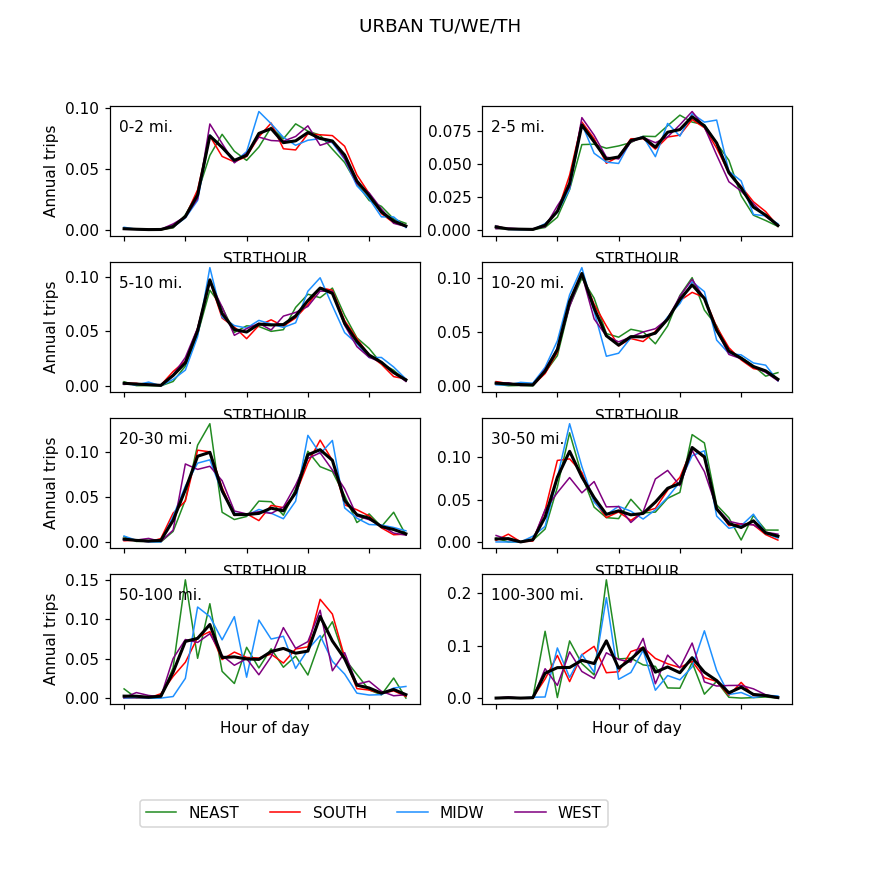

('NEAST', 'URB', 'TU/WE/TH')
('SOUTH', 'URB', 'TU/WE/TH')
('MIDW', 'URB', 'TU/WE/TH')
('WEST', 'URB', 'TU/WE/TH')


In [96]:
def plot_dists_by_region(plotdata, regions=['NEAST','SOUTH','MIDW','WEST'], urbrur='URB', wktime='WEEKDAY',
                         alldata = None,
                         colors=None):
    fig = plt.figure()
    gs = gridspec.GridSpec(nrows=4, ncols=2, bottom=0.2)

    for i in range(len(mibins[:-1])):
        fig.add_subplot(gs[i/2, i%2])

    axs = fig.axes
    
    if not colors:
        colors=['forestgreen','red','dodgerblue','purple']

    #plotdata = dists.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
    for i, reg in enumerate(regions):
        sel=(reg,urbrur,wktime)
        print sel
        #plotdata = dists.loc[sel].unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
        #plotdata.index = np.arange(24)
        plotdata[sel].plot(subplots=True, legend=None, color=colors[i], ax=axs, linewidth=1)

    if alldata is not None:
        alldata[(urbrur,wktime)].plot(subplots=True, legend=None,color='k', ax=axs, linewidth=2)
    for i, ax in enumerate(axs):
        col = plotdata[sel].columns[i]
        miles = col.split('-')
        ax.annotate(str(miles[0])+'-'+str(miles[1])+' mi.', [0.03,0.8], xycoords='axes fraction')
        if i > 5:
            ax.set_xlabel('Hour of day')
            
        if i % 2 == 0:
            ax.set_ylabel('Annual trips')

    plt.legend(ax.lines, regions,ncol=4, loc=2, bbox_to_anchor=(0.15,0.1), bbox_transform=fig.transFigure)
    
    if urbrur == 'URB': 
        urname='URBAN' 
    else: 
        urname='RURAL'
    fig.suptitle(urname+' '+wktime)
    
plt.rcParams['figure.figsize'] = [8, 8]    
plotdata = hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
plot_dists_by_region(plotdata, urbrur='URB', wktime='TU/WE/TH', alldata=alldata)

In [97]:
dist_hour_hists = dist_hists.copy()
dist_hour_hists.rename(columns={'COUNTSRAW':'NRAW', 'COUNTSWTD':'NWTD'},inplace=True)
dist_hour_hists

AVGDIST REGION     NRAW          NWTD
CDIVLS URBRURS WKTIME   MILEBIN                                          
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08
                        2-5        3.229061   MIDW   1272.0  3.689536e+08
                        5-10       7.307186   MIDW    962.0  2.574709e+08
                        10-20     14.369085   MIDW    872.0  2.688098e+08
                        20-30     24.308613   MIDW    367.0  1.130752e+08
                        30-50     38.296500   MIDW    294.0  7.924429e+07
                        50-100    65.738626   MIDW    147.0  3.291124e+07
                        100-300  164.462368   MIDW     68.0  1.262960e+07
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08
                        2-5        3.263062   MIDW    516.0  3.306223e+08
                        5-10       7.174956   MIDW    363.0  2.181214e+08
                        10-20     13.890219   MIDW    374.0  2.274015e+08
                        20-30     24.590622   MIDW    135.0  9.867586e+07
                        30-50     39.594713   MIDW    108.0  7.227111e+07
                        50-100    65.750533   MIDW     92.0  3.914405e+07
                        100-300  157.425613   MIDW     31.0  1.656451e+07
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08
                        2-5        3.265039   MIDW   1835.0  5.502475e+08
                        5-10       7.273006   MIDW   1437.0  4.489847e+08
                        10-20     14.320166   MIDW   1346.0  5.147868e+08
                        20-30     24.388382   MIDW    558.0  1.765248e+08
                        30-50     38.339401   MIDW    459.0  1.483422e+08
                        50-100    67.393056   MIDW    177.0  4.410430e+07
                        100-300  156.786339   MIDW     59.0  1.006733e+07
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09
                        2-5        3.300086   MIDW   5525.0  2.255926e+09
                        5-10       7.133211   MIDW   3646.0  1.564843e+09
                        10-20     14.079526   MIDW   2614.0  1.148814e+09
                        20-30     23.939033   MIDW    812.0  4.235249e+08
                        30-50     37.506699   MIDW    505.0  2.503524e+08
...                                     ...    ...      ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08
                        10-20     14.095486  SOUTH    696.0  1.252788e+08
                        20-30     24.975269  SOUTH    275.0  4.497832e+07
                        30-50     38.647350  SOUTH    286.0  3.976651e+07
                        50-100    66.814141  SOUTH    170.0  2.805630e+07
                        100-300  177.377809  SOUTH     47.0  6.633365e+06
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08
                        50-100    68.503032  SOUTH    408.0  4.765194e+07
                        100-300  170.322644  SOUTH    261.0  3.139168e+07
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08
                        10-20     14.151696  SOUTH   1830.0  5.535825e+08
                        20-30     24.027017  SOUTH    686.0  2.161418e+08
                        30-50     37.700176  SOUTH    369.0  1.080243e+08
                        50-100    71.025019  SOUTH    210.0  7.147218e+07
                        100-300  165.758

In [98]:
hcols=[]
for h in range(24):
    col='NWTD_'+format(h,'02d')
    hcols.append(col)
    dist_hour_hists[h]=0
    
dist_hour_hists

AVGDIST REGION     NRAW          NWTD  0  \
CDIVLS URBRURS WKTIME   MILEBIN                                                
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08  0   
                        2-5        3.229061   MIDW   1272.0  3.689536e+08  0   
                        5-10       7.307186   MIDW    962.0  2.574709e+08  0   
                        10-20     14.369085   MIDW    872.0  2.688098e+08  0   
                        20-30     24.308613   MIDW    367.0  1.130752e+08  0   
                        30-50     38.296500   MIDW    294.0  7.924429e+07  0   
                        50-100    65.738626   MIDW    147.0  3.291124e+07  0   
                        100-300  164.462368   MIDW     68.0  1.262960e+07  0   
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08  0   
                        2-5        3.263062   MIDW    516.0  3.306223e+08  0   
                        5-10       7.174956   MIDW    363.0  2.181214e+08  0   
                        10-20     13.890219   MIDW    374.0  2.274015e+08  0   
                        20-30     24.590622   MIDW    135.0  9.867586e+07  0   
                        30-50     39.594713   MIDW    108.0  7.227111e+07  0   
                        50-100    65.750533   MIDW     92.0  3.914405e+07  0   
                        100-300  157.425613   MIDW     31.0  1.656451e+07  0   
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08  0   
                        2-5        3.265039   MIDW   1835.0  5.502475e+08  0   
                        5-10       7.273006   MIDW   1437.0  4.489847e+08  0   
                        10-20     14.320166   MIDW   1346.0  5.147868e+08  0   
                        20-30     24.388382   MIDW    558.0  1.765248e+08  0   
                        30-50     38.339401   MIDW    459.0  1.483422e+08  0   
                        50-100    67.393056   MIDW    177.0  4.410430e+07  0   
                        100-300  156.786339   MIDW     59.0  1.006733e+07  0   
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09  0   
                        2-5        3.300086   MIDW   5525.0  2.255926e+09  0   
                        5-10       7.133211   MIDW   3646.0  1.564843e+09  0   
                        10-20     14.079526   MIDW   2614.0  1.148814e+09  0   
                        20-30     23.939033   MIDW    812.0  4.235249e+08  0   
                        30-50     37.506699   MIDW    505.0  2.503524e+08  0   
...                                     ...    ...      ...           ... ..   
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08  0   
                        10-20     14.095486  SOUTH    696.0  1.252788e+08  0   
                        20-30     24.975269  SOUTH    275.0  4.497832e+07  0   
                        30-50     38.647350  SOUTH    286.0  3.976651e+07  0   
                        50-100    66.814141  SOUTH    170.0  2.805630e+07  0   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06  0   
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09  0   
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09  0   
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08  0   
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08  0   
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08  0   
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08  0   
                        50-100    68.503032  SOUTH    408.0  4.765194e+07  0   
                        100-300  170.322644  SOUTH    261.0  3.139168e+07  0   
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09  0   
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09  0   
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08  0   
                        10-20     14

In [99]:
for reg in dist_hists.index.levels[0]:
    print reg
    dist_hour_hists.loc[reg,range(24)] = \
        hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(\
                                            dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hists.loc[reg].index].values
        #The final reindexing by dist_hists.loc[reg].index is essential to get the rows in the right order!

dist_hour_hists
#hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T

ENC
ESC
MAT-NL
MAT-NY
MTN
NENG
PAC-CA
PAC-NL
SAT-FL
SAT-NL
WNC
WSC-NL
WSC-TX


AVGDIST REGION     NRAW          NWTD  \
CDIVLS URBRURS WKTIME   MILEBIN                                             
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08   
                        2-5        3.229061   MIDW   1272.0  3.689536e+08   
                        5-10       7.307186   MIDW    962.0  2.574709e+08   
                        10-20     14.369085   MIDW    872.0  2.688098e+08   
                        20-30     24.308613   MIDW    367.0  1.130752e+08   
                        30-50     38.296500   MIDW    294.0  7.924429e+07   
                        50-100    65.738626   MIDW    147.0  3.291124e+07   
                        100-300  164.462368   MIDW     68.0  1.262960e+07   
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08   
                        2-5        3.263062   MIDW    516.0  3.306223e+08   
                        5-10       7.174956   MIDW    363.0  2.181214e+08   
                        10-20     13.890219   MIDW    374.0  2.274015e+08   
                        20-30     24.590622   MIDW    135.0  9.867586e+07   
                        30-50     39.594713   MIDW    108.0  7.227111e+07   
                        50-100    65.750533   MIDW     92.0  3.914405e+07   
                        100-300  157.425613   MIDW     31.0  1.656451e+07   
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08   
                        2-5        3.265039   MIDW   1835.0  5.502475e+08   
                        5-10       7.273006   MIDW   1437.0  4.489847e+08   
                        10-20     14.320166   MIDW   1346.0  5.147868e+08   
                        20-30     24.388382   MIDW    558.0  1.765248e+08   
                        30-50     38.339401   MIDW    459.0  1.483422e+08   
                        50-100    67.393056   MIDW    177.0  4.410430e+07   
                        100-300  156.786339   MIDW     59.0  1.006733e+07   
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09   
                        2-5        3.300086   MIDW   5525.0  2.255926e+09   
                        5-10       7.133211   MIDW   3646.0  1.564843e+09   
                        10-20     14.079526   MIDW   2614.0  1.148814e+09   
                        20-30     23.939033   MIDW    812.0  4.235249e+08   
                        30-50     37.506699   MIDW    505.0  2.503524e+08   
...                                     ...    ...      ...           ...   
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08   
                        10-20     14.095486  SOUTH    696.0  1.252788e+08   
                        20-30     24.975269  SOUTH    275.0  4.497832e+07   
                        30-50     38.647350  SOUTH    286.0  3.976651e+07   
                        50-100    66.814141  SOUTH    170.0  2.805630e+07   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06   
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09   
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09   
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08   
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08   
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08   
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08   
                        50-100    68.503032  SOUTH    408.0  4.765194e+07   
                        100-300  170.322644  SOUTH    261.0  3.139168e+07   
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09   
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09   
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08   
                        10-20     14.151696  SOUTH   1830.0  5.535825e+08   
                        20-30     24.027017  SOUTH    686.0  2.161418e+08   
                        30-50   

In [100]:
hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hour_hists.loc[reg].index]

STRTHOUR                            0             1             2   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      2.335581e+05  6.212197e+05  2.040245e+04   
                 2-5      2.749762e+05  9.347326e+04  0.000000e+00   
                 5-10     4.123954e+05  3.850356e+04  2.032797e+04   
                 10-20    3.572537e+05  1.536606e+04  1.926746e+04   
                 20-30    2.678795e+05  1.470129e+04  6.112997e+03   
                 30-50    3.411623e+04  6.281811e+04  5.112861e+03   
                 50-100   4.776816e+05  4.132439e+04  9.523522e+03   
                 100-300  4.934883e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      4.376469e+05  1.616513e+04  1.272498e+05   
                 2-5      2.320813e+05  3.661899e+04  0.000000e+00   
                 5-10     5.502524e+04  4.762659e+04  9.071333e+02   
                 10-20    6.488404e+04  2.200391e+05  2.725462e+05   
                 20-30    0.000000e+00  9.887718e+03  0.000000e+00   
                 30-50    0.000000e+00  2.835558e+05  0.000000e+00   
                 50-100   5.904606e+03  4.484626e+04  0.000000e+00   
                 100-300  2.511856e+03  0.000000e+00  0.000000e+00   
        TU/WE/TH 0-2      8.612576e+05  2.633612e+05  1.610218e+05   
                 2-5      5.825093e+04  4.137617e+05  2.235264e+05   
                 5-10     2.610727e+05  6.011214e+03  6.197169e+04   
                 10-20    2.225512e+05  8.472143e+04  0.000000e+00   
                 20-30    1.059272e+05  2.167999e+03  1.150998e+05   
                 30-50    1.409835e+04  1.101768e+04  7.589678e+04   
                 50-100   0.000000e+00  6.841933e+04  0.000000e+00   
                 100-300  0.000000e+00  5.575527e+05  0.000000e+00   
URB     MO/FR    0-2      3.433367e+06  1.475182e+06  1.050223e+06   
                 2-5      3.306051e+06  2.226962e+06  4.191389e+05   
                 5-10     3.914560e+06  2.144325e+06  5.611240e+05   
                 10-20    2.066970e+06  1.103553e+06  2.672805e+06   
                 20-30    9.595366e+05  6.117420e+05  1.761174e+05   
                 30-50    2.368666e+05  1.095353e+06  4.190024e+05   
                 50-100   1.945967e+05  4.408681e+04  0.000000e+00   
                 100-300  2.281332e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      1.161871e+06  3.464329e+06  3.647751e+05   
                 2-5      4.140848e+06  4.155160e+06  3.005732e+05   
                 5-10     5.612388e+06  2.067923e+06  1.153903e+06   
                 10-20    4.098028e+06  2.344895e+06  2.300690e+05   
                 20-30    9.138703e+05  8.146923e+05  9.121484e+04   
                 30-50    3.805389e+05  4.755704e+05  9.492544e+04   
                 50-100   2.748495e+05  2.039629e+05  1.600974e+05   
                 100-300  1.662832e+05  1.978875e+05  0.000000e+00   
        TU/WE/TH 0-2      1.831140e+06  9.559667e+05  3.965889e+05   
                 2-5      4.539151e+06  1.330707e+06  9.446603e+05   
                 5-10     3.660974e+06  2.486431e+06  1.708697e+06   
                 10-20    3.186913e+06  2.216828e+06  1.571684e+06   
                 20-30    1.518560e+06  8.530606e+05  5.321047e+05   
                 30-50    7.855360e+05  8.756794e+05  2.076054e+04   
                 50-100   1.419314e+05  1.343973e+05  6.078420e+04   
                 100-300  1.675078e+03  3.015480e+04  0.000000e+00   

STRTHOUR                            3             4             5   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      3.104149e+05  2.109656e+05  2.086083e+06   
                 2-5      1.945651e+04  8.192051e+05  1.726766e+06   
                 5-10     4.263229e+04  8.208717e+05  8.898945e+05   
                 10-20    3.160974e+03  3.753176e+05  1.780269e+06   
                 20-30    5.065931e+04  3.558228e+05  5.880137e+05   
         

In [101]:
#double-check avg mileage again
dist_hour_hists[range(24)].mul(dist_hour_hists['AVGDIST'], axis=0).sum(axis=1).sum()/dist_hour_hists[range(24)].sum(axis=1).sum()


8.895831871128166

In [102]:
dist_hour_hists[range(24)].sum(axis=1)

CDIVLS  URBRURS  WKTIME    MILEBIN
ENC     RUR      MO/FR     0-2        7.172323e+08
                           2-5        3.689536e+08
                           5-10       2.574709e+08
                           10-20      2.688098e+08
                           20-30      1.130752e+08
                           30-50      7.924429e+07
                           50-100     3.291124e+07
                           100-300    1.262960e+07
                 SA/SU     0-2        5.904250e+08
                           2-5        3.306223e+08
                           5-10       2.181214e+08
                           10-20      2.274015e+08
                           20-30      9.867586e+07
                           30-50      7.227111e+07
                           50-100     3.914405e+07
                           100-300    1.656451e+07
                 TU/WE/TH  0-2        8.372957e+08
                           2-5        5.502475e+08
                           5-10       4.489847e

<IPython.core.display.Javascript object>


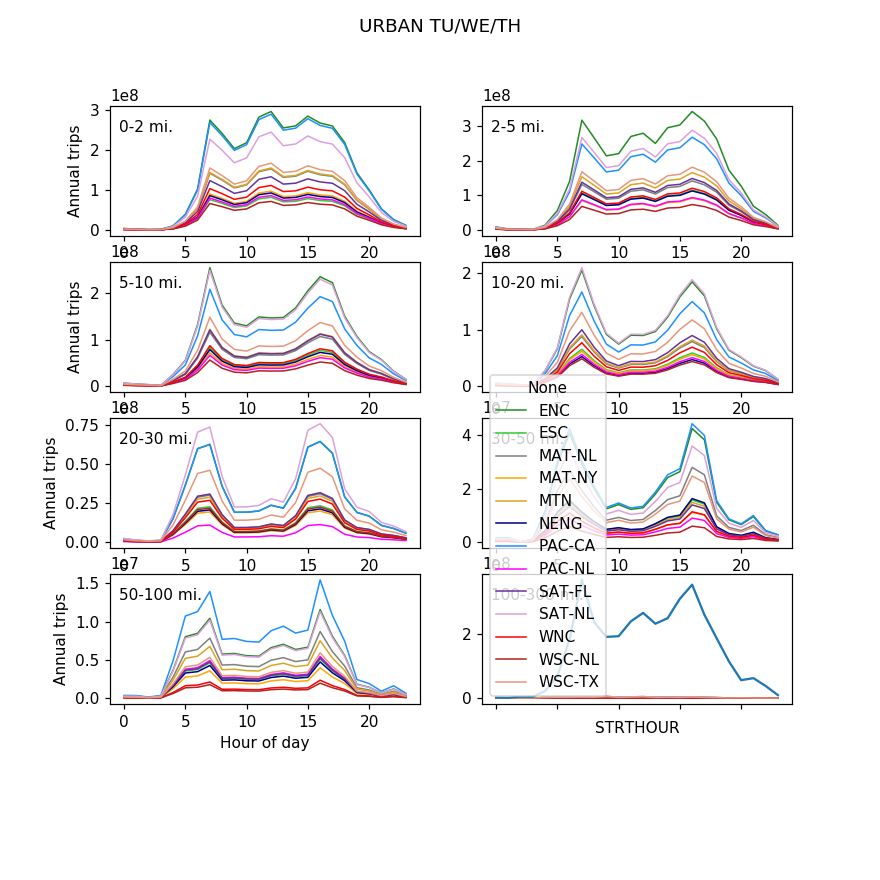

('ENC', 'URB', 'TU/WE/TH')
('ESC', 'URB', 'TU/WE/TH')
('MAT-NL', 'URB', 'TU/WE/TH')
('MAT-NY', 'URB', 'TU/WE/TH')
('MTN', 'URB', 'TU/WE/TH')
('NENG', 'URB', 'TU/WE/TH')
('PAC-CA', 'URB', 'TU/WE/TH')
('PAC-NL', 'URB', 'TU/WE/TH')
('SAT-FL', 'URB', 'TU/WE/TH')
('SAT-NL', 'URB', 'TU/WE/TH')
('WNC', 'URB', 'TU/WE/TH')
('WSC-NL', 'URB', 'TU/WE/TH')
('WSC-TX', 'URB', 'TU/WE/TH')


In [103]:
regions = dist_hour_hists.index.levels[0]
len(regions)
colors=['forestgreen','limegreen','gray', 'orange', 'goldenrod','darkblue','dodgerblue','magenta','rebeccapurple','plum',
       'red','firebrick','darksalmon']
plot_dists_by_region(dist_hour_hists[range(24)].T,regions=regions,colors=colors, urbrur='URB',wktime='TU/WE/TH')

In [104]:
if include_transit:
    tag = 'with_transit'
else:
    tag='no_transit'
hourly_profiles_agg.to_csv(data_dir+'\\binned_dists\\hourly_profiles_urb_rur_'+tag+'.csv')
dist_hists.drop('REGION', axis=1).to_csv(data_dir+'\\binned_dists\\dist_hists_by_region_'+tag+'.csv') #drop region to avoid confusion

In [105]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.000999
                         1               8.0  9.804437e+06  0.002658
                         2               1.0  3.220029e+05  0.000087
                         3               1.0  4.899141e+06  0.001328
                         4              27.0  3.329577e+06  0.000903
                         5              88.0  3.292373e+07  0.008924
                         6             222.0  8.691726e+07  0.023559
                         7             637.0  2.670100e+08  0.072375
                         8             531.0  2.237291e+08  0.060643
                         9             702.0  2.244169e+08  0.060829
                         10            813.0  2.604827e+08  0.070605
                         11            975.0  3.135245e+08  0.084983
                         12            989.0  3.570667e+08  0.096785
                         13            805.0  2.910628e+08  0.078894
                         14            805.0  2.662460e+08  0.072167
                         15            878.0  3.368963e+08  0.091318
                         16            789.0  3.058243e+08  0.082895
                         17            606.0  2.502709e+08  0.067837
                         18            398.0  1.782346e+08  0.048311
                         19            220.0  9.051126e+07  0.024534
                         20            181.0  7.440041e+07  0.020167
                         21            106.0  5.901752e+07  0.015997
                         22             45.0  2.748506e+07  0.007450
                         23             29.0  2.121847e+07  0.005751
                 2-5     0               6.0  4.572063e+06  0.002037
                         1               4.0  1.554191e+06  0.000692
                         3               2.0  3.235058e+05  0.000144
                         4              32.0  1.362102e+07  0.006068
                         5              83.0  2.871115e+07  0.012790
                         6             208.0  9.235502e+07  0.041143
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            168.0  6.232830e+07  0.072412
                         18            114.0  4.301895e+07  0.049979
                         19             65.0  1.411913e+07  0.016403
                         20             68.0  1.104267e+07  0.012829
                         21             36.0  5.331993e+06  0.006195
                         22             23.0  9.409047e+06  0.010931
                         23              8.0  3.762486e+06  0.004371
                 100-300 0               1.0  1.338488e+04  0.000042
                         1               2.0  2.409549e+05  0.000752
                         3               4.0  2.328788e+05  0.000727
                         4              41.0  1.519647e+07  0.047441
                         5              46.0  1.860461e+07  0.058080
                         6              87.0  1.870351e+07  0.058389
                         7             100.0  2.307079e+07  0.072023
                         8             105.0  2.110372e+07  0.065882
                         9             128.0  3.497615e+07  0.109190
                         10             94.0  1.826812e+07  0.057030
                         11            109.0  2.376506e+07  0.074190
                         12            131.0  3.064732e+07  0.095676
                         13             89.0  1.584287e+07  0.049459
                         14            121.0  1.901336e+07  0.059356
                         15             93.0  1.548741e+07  0.048349
                         16             89.0  2.468002e+07  0.077047
                         17             51.0  1.580519e+07  0.049341
                         18             45.0  1.072476e+07  0.033481
                         19      

## Compute seasonal variation

In [116]:
trippub['MONTH'] = trippub['TDAYDATE'].astype(str).str.slice(-2).astype(int)
trippub['SEASON'] = 'DEC-FEB'
trippub.loc[trippub['MONTH'].isin([3,4,5]), 'SEASON'] = 'MAR-MAY'
trippub.loc[trippub['MONTH'].isin([6,7,8]), 'SEASON'] = 'JUN-AUG'
trippub.loc[trippub['MONTH'].isin([9,10,11]), 'SEASON'] = 'SEP-NOV'
trippub.groupby('SEASON')['WTTRDFIN'].sum()

SEASON
DEC-FEB    5.145153e+10
JUN-AUG    5.785653e+10
MAR-MAY    5.898109e+10
SEP-NOV    5.354672e+10
Name: WTTRDFIN, dtype: float64

<IPython.core.display.Javascript object>


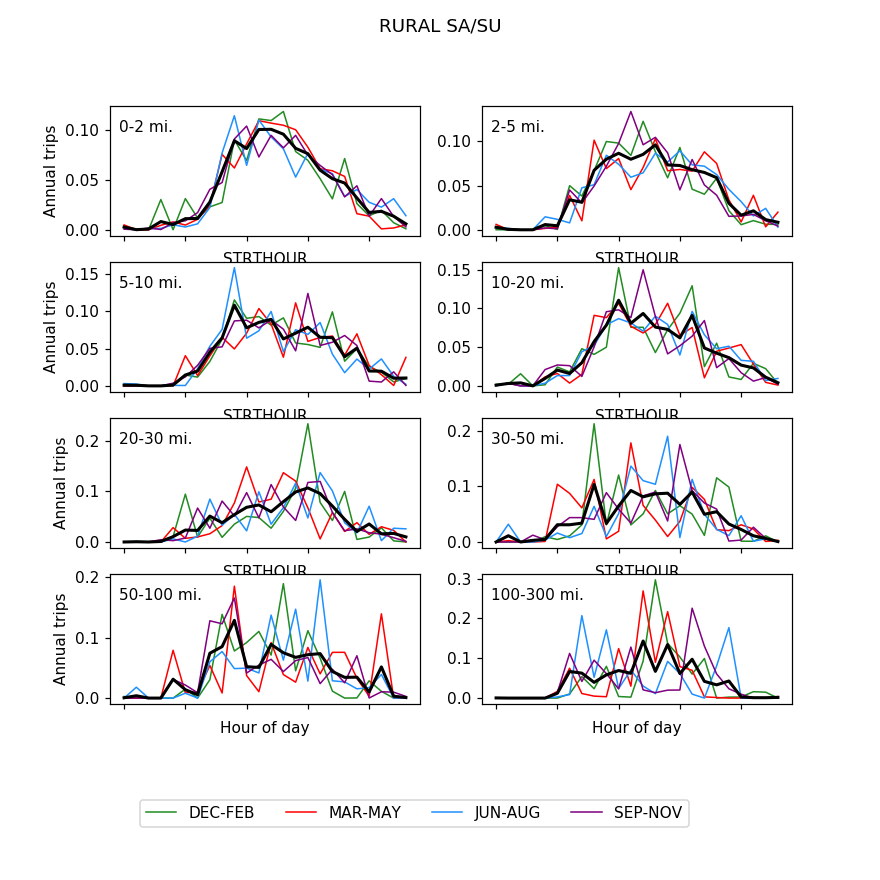

('DEC-FEB', 'RUR', 'SA/SU')
('MAR-MAY', 'RUR', 'SA/SU')
('JUN-AUG', 'RUR', 'SA/SU')
('SEP-NOV', 'RUR', 'SA/SU')


In [149]:
#Now plot seasonal variation
hourly_profiles_season = trippub.groupby(['SEASON', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
hourly_profiles_season['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles_season.index.levels[0].unique() 
            for b in hourly_profiles_season.index.levels[1].unique() 
            for c in hourly_profiles_season.index.levels[2].unique() 
            for d in hourly_profiles_season.index.levels[3].unique()]:
    pct=hourly_profiles_season.loc[row,'COUNTSWTD']/(hourly_profiles_season.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_season.loc[row+(h,), 'TRIPPCT'] = pct[h]
plotdata = hourly_profiles_season.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T


<IPython.core.display.Javascript object>


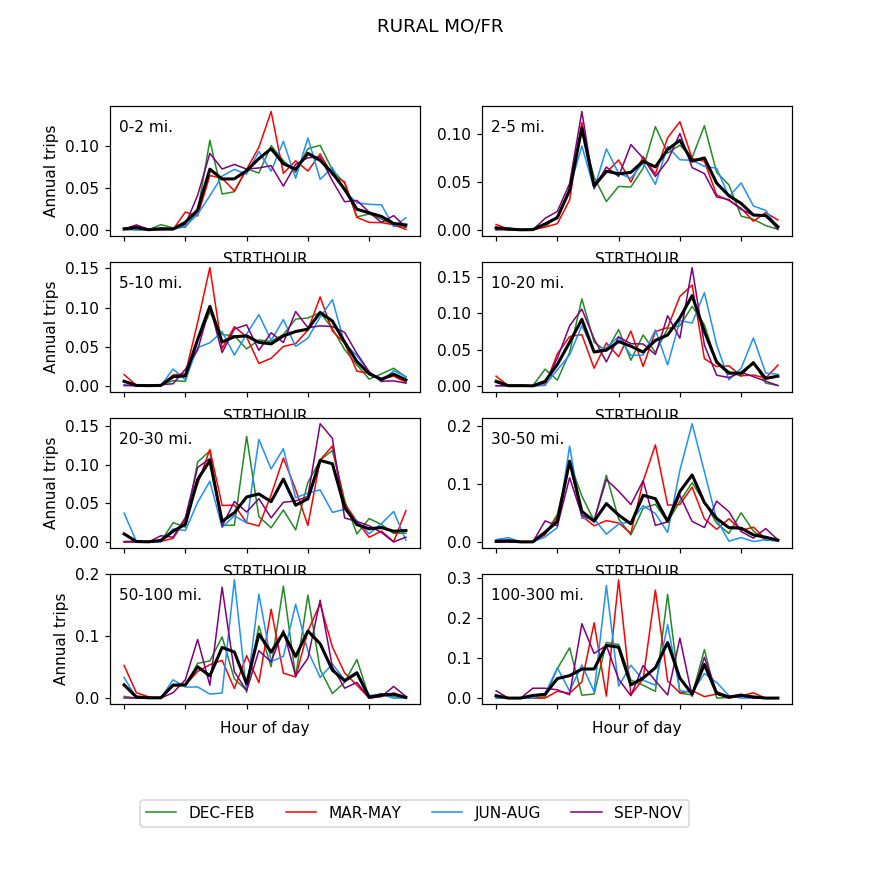

('DEC-FEB', 'RUR', 'MO/FR')
('MAR-MAY', 'RUR', 'MO/FR')
('JUN-AUG', 'RUR', 'MO/FR')
('SEP-NOV', 'RUR', 'MO/FR')


In [152]:
plot_dists_by_region(plotdata, regions=['DEC-FEB','MAR-MAY','JUN-AUG','SEP-NOV'], urbrur='RUR', wktime='MO/FR', alldata=alldata)

<IPython.core.display.Javascript object>


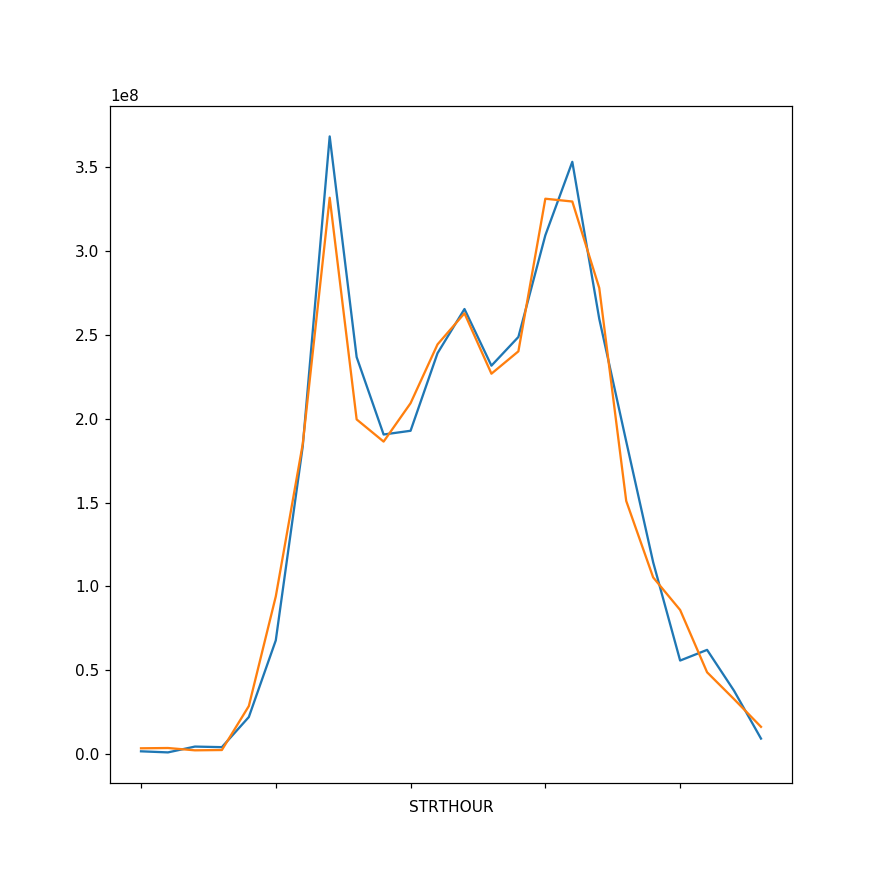

In [134]:
ax = trips_by_dist_season.loc[('DEC-FEB','RUR','TU/WE/TH'), 'COUNTSWTD'].plot()
trips_by_dist_season.loc[('SEP-NOV','RUR','TU/WE/TH'), 'COUNTSWTD'].plot(ax=ax)

In [143]:
trips_by_dist_season.loc['JUN-AUG'].div(trips_by_dist)

COUNTSRAW  COUNTSWTD
URBRURS WKTIME   STRTHOUR                      
RUR     MO/FR    0          0.326087   0.359059
                 1          0.115385   0.066030
                 2          0.111111   0.214261
                 3          0.111111   0.017251
                 4          0.287611   0.296804
                 5          0.275720   0.191678
                 6          0.258711   0.236547
                 7          0.218824   0.191485
                 8          0.267857   0.281781
                 9          0.284061   0.319414
                 10         0.280154   0.264315
                 11         0.265132   0.329628
                 12         0.263180   0.247525
                 13         0.285914   0.324077
                 14         0.253292   0.244932
                 15         0.259548   0.287198
                 16         0.244120   0.236073
                 17         0.259089   0.318036
                 18         0.259984   0.313263
                 19         0.285903   0.303604
                 20         0.304114   0.407419
                 21         0.305851   0.471438
                 22         0.281407   0.333873
                 23         0.250000   0.416808
        SA/SU    0          0.193548   0.214369
                 1          0.500000   0.719726
                 2          0.250000   0.143554
                 3          0.125000   0.041107
                 4          0.328125   0.273914
                 5          0.267606   0.136205
...                              ...        ...
URB     SA/SU    18         0.278328   0.263079
                 19         0.284627   0.284490
                 20         0.298482   0.289172
                 21         0.280639   0.289074
                 22         0.290055   0.278143
                 23         0.248544   0.314127
        TU/WE/TH 0          0.278736   0.227794
                 1          0.357895   0.259553
                 2          0.356436   0.363632
                 3          0.170543   0.278137
                 4          0.286420   0.298594
                 5          0.259702   0.260742
                 6          0.256916   0.256989
                 7          0.233449   0.233492
                 8          0.260692   0.255621
                 9          0.285387   0.297337
                 10         0.280902   0.288296
                 11         0.271802   0.279629
                 12         0.276660   0.288239
                 13         0.277390   0.283123
                 14         0.257649   0.253599
                 15         0.247639   0.246139
                 16         0.257031   0.268511
                 17         0.264974   0.274470
                 18         0.267621   0.265192
                 19         0.280440   0.264395
                 20         0.285694   0.286545
                 21         0.289851   0.296989
                 22         0.314330   0.258223
                 23         0.310945   0.357732

[144 rows x 2 columns]

In [144]:
0.194661 + 0.262743 + 0.184863 + 0.357732

0.9999990000000001

In [108]:
trippub

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DROP_PRK,DRVRCNT,DRVR_FLG,DWELTIME,EDUC,ENDTIME,...,WHYTRP90,WORKER,WRKCOUNT,WTTRDFIN,CDIVLS,REGION,URBRURS,WKTIME,MILEBIN,STRTHOUR
0,53,5,3,1,-1,3,1,295,3,1015,...,5,2,1,75441.905796,SAT-NL,SOUTH,URB,MO/FR,5-10,9
1,53,5,3,1,-1,3,1,-9,3,1530,...,5,2,1,75441.905796,SAT-NL,SOUTH,URB,MO/FR,5-10,15
2,53,5,3,1,-1,3,1,540,3,900,...,1,1,1,71932.645806,SAT-NL,SOUTH,URB,MO/FR,50-100,6
3,53,5,3,1,-1,3,1,-9,3,2030,...,1,1,1,71932.645806,SAT-NL,SOUTH,URB,MO/FR,50-100,17
4,53,5,3,1,-1,3,1,330,2,900,...,5,2,1,80122.686739,SAT-NL,SOUTH,URB,MO/FR,2-5,8
5,53,5,3,1,-1,3,1,-9,2,1445,...,5,2,1,80122.686739,SAT-NL,SOUTH,URB,MO/FR,2-5,14
6,32,3,2,1,-1,2,1,720,5,1130,...,1,1,2,23062.857428,ENC,MIDW,URB,TU/WE/TH,5-10,11
7,32,3,2,1,-1,2,1,-9,5,2340,...,1,1,2,23062.857428,ENC,MIDW,URB,TU/WE/TH,5-10,23
8,23,2,1,1,-1,1,1,55,5,605,...,10,1,1,21522.690513,MAT-NY,NEAST,URB,TU/WE/TH,2-5,5
9,23,2,1,1,-1,1,1,15,5,715,...,10,1,1,21522.690513,MAT-NY,NEAST,URB,TU/WE/TH,2-5,6
